In [2]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, recall_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import sqlite3
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
conn = sqlite3.connect(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\data.db')
cursor = conn.cursor()
query = ('''
WITH mean_deposite as (
    select 
         client_id,
         AVG(balance) as mean_balance,
         MAX(balance) as max_balance,
         MIN(balance) as min_balance,
         MAX(balance)-MIN(balance) as dif_balance,
         currency
    from balances
    group by 1
)
Select * 
from inv_campaign_eval
left join client
on inv_campaign_eval.client_id = client.client_id
left join client_products
on inv_campaign_eval.client_id = client_products.client_id
left join mean_deposite
on inv_campaign_eval.client_id = mean_deposite.client_id''')
df = pd.read_sql_query(query, conn)

df.head()

,client_id,poutcome,client_id,age,job,marital,education,gender,client_id,has_deposits,loan,has_insurance,has_mortgage,client_id,mean_balance,max_balance,min_balance,dif_balance,currency
0,249789938,success,249789938,38.0,services,married,secondary,M,249789938,yes,no,n,no,249789938,2669.532734,2775.615374,2515.500059,260.115315,CZK
1,1504633819,failure,1504633819,38.0,management,married,tertiary,M,1504633819,no,yes,n,yes,1504633819,5440.862334,5529.866975,5344.385346,185.481629,CZK
2,1952195738,success,1952195738,34.0,services,married,secondary,M,1952195738,yes,yes,n,no,1952195738,2922.958852,3016.314818,2852.824056,163.490762,CZK
3,989726384,success,989726384,62.0,retired,married,secondary,F,989726384,yes,no,n,no,989726384,3124.614843,3212.174671,3011.445910,200.728761,CZK
4,1971878545,failure,1971878545,36.0,management,single,tertiary,M,1971878545,yes,no,n,no,1971878545,474.083033,571.028715,362.809777,208.218939,CZK


In [4]:
import joblib


age_pipeline = joblib.load(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\age_pipeline.pkl')
missing_age_indices = df['age'].isnull()
predicted_ages = age_pipeline.predict(df[missing_age_indices])

# Step 2: Replace missing values with predicted values
df.loc[missing_age_indices, 'age'] = predicted_ages

In [5]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [6]:
df = df.T.drop_duplicates().T
df.mean_balance = pd.to_numeric(df.mean_balance)
df.max_balance = pd.to_numeric(df.max_balance)
df.min_balance = pd.to_numeric(df.min_balance)
df.dif_balance = pd.to_numeric(df.dif_balance)
df.age=pd.to_numeric(df.age)
df.age_group=pd.to_numeric(df.age_group)

In [7]:
rate = {'CZK': 1, 'USD': 23, 'EUR': 25}

df.mean_balance = df.apply(lambda row: row['mean_balance'] * rate[row['currency']], axis=1)
df.max_balance = df.apply(lambda row: row['max_balance'] * rate[row['currency']], axis=1)
df.min_balance = df.apply(lambda row: row['min_balance'] * rate[row['currency']], axis=1)

In [8]:
query1 = ('''
Select * 
from inv_campaign_eval
left join balances
on inv_campaign_eval.client_id = balances.client_id''')
dif_bal = pd.read_sql_query(query1, conn)
dif_bal = dif_bal.T.drop_duplicates().T

rate = {'CZK': 1, 'USD': 23, 'EUR': 25}
dif_bal.balance = dif_bal.apply(lambda row: row['balance'] * rate[row['currency']], axis=1)

dif_bal['balance_change'] = dif_bal.groupby('client_id')['balance'].diff()
dif_bal['balance_change'].fillna(0, inplace=True)

sum_dif = dif_bal.groupby('client_id')['balance_change'].apply(lambda arr: sum(x ** 2 for x in arr))
dif_bal = dif_bal.merge(sum_dif, on='client_id', how='left')
dif_bal

dif_bal.drop(columns=['date', 'balance', 'balance_change_x', 'poutcome', 'currency'], inplace=True)
dif_bal.drop_duplicates(inplace=True)

df = df.merge(dif_bal, on='client_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         2299 non-null   object 
 1   poutcome          2299 non-null   object 
 2   age               2299 non-null   float64
 3   job               2216 non-null   object 
 4   marital           2299 non-null   object 
 5   education         2299 non-null   object 
 6   gender            2299 non-null   object 
 7   has_deposits      2299 non-null   object 
 8   loan              2299 non-null   object 
 9   has_insurance     2299 non-null   object 
 10  has_mortgage      2299 non-null   object 
 11  mean_balance      2299 non-null   float64
 12  max_balance       2299 non-null   float64
 13  min_balance       2299 non-null   float64
 14  dif_balance       2299 non-null   float64
 15  currency          2299 non-null   object 
 16  age_group         2299 non-null   int64  


C:\Users\spiri\AppData\Local\Temp\ipykernel_11084\3840978348.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dif_bal['balance_change'].fillna(0, inplace=True)


In [61]:
y = df.poutcome
X = df[['age', 'has_deposits', 'loan', 'has_mortgage', 'balance_change_y','education' ,'age_group']]
enc = LabelEncoder()
y=enc.fit_transform(y)

label_encoders = {}
for col in ['has_deposits', 'loan', 'has_mortgage','education']:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\spiri\AppData\Local\Temp\ipykernel_11084\4293974849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoders[col].fit_transform(X[col])
C:\Users\spiri\AppData\Local\Temp\ipykernel_11084\4293974849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoders[col].fit_transform(X[col])
C:\Users\spiri\AppData\Local\Temp\ipykernel_11084\4293974849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2, random_state=42),
    "Random Forest":RandomForestClassifier(random_state=42, n_estimators= 150, min_samples_split= 10, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 10, criterion= 'entropy', bootstrap= False),
    "Gradient Boosting": GradientBoostingClassifier(warm_start= False,subsample= 0.7,random_state= 42,n_estimators= 150,min_samples_split= 4,min_samples_leaf= 3,max_features= None,max_depth= 6,loss= 'exponential',learning_rate= 0.01,criterion= 'friedman_mse'),
    "AdaBoost": AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 0.01, n_estimators= 50, random_state=42),
}

In [63]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, recall_score

results = []

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Classification Report": report,
        "FPR": fpr,
        "TPR": tpr,
        "AUC": roc_auc})
    print("Accuracy with " + name +" classifier: {:.2f}%".format(accuracy * 100) + ' recall score is:{:.2f}%'.format(recall * 100))

Accuracy with Decision Tree classifier: 70.22% recall score is:68.49%
Accuracy with Random Forest classifier: 69.78% recall score is:75.80%
Accuracy with Gradient Boosting classifier: 70.22% recall score is:76.26%
Accuracy with AdaBoost classifier: 69.13% recall score is:89.95%


In [52]:
from sklearn.model_selection import GridSearchCV


parameters = {
     'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest.
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split.
    'max_depth': [None, 10, 20, 30],  # The maximum depth of the tree.
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node.
    'min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node.
    'max_features': ['auto', 'sqrt'],  # The number of features to consider when looking for the best split.
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees.
    'random_state': [42] # Controls the randomness of the estimator.
}
dt = RandomForestClassifier()
gs = RandomizedSearchCV(dt, parameters, n_iter=100,  scoring='recall')
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
results

c:\Users\spiri\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
255 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
255 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\spiri\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\spiri\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\spiri\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.349332,0.011318,0.011338,0.002364,42,150,5,1,sqrt,20,...,True,"{'random_state': 42, 'n_estimators': 150, 'min...",0.701754,0.707602,0.711765,0.747059,0.705882,0.714813,0.016440,30
1,0.349640,0.012877,0.012663,0.004552,42,150,2,2,sqrt,None,...,False,"{'random_state': 42, 'n_estimators': 150, 'min...",0.660819,0.672515,0.711765,0.741176,0.682353,0.693725,0.029117,40
2,0.000000,0.000000,0.000000,0.000000,42,200,5,1,auto,30,...,False,"{'random_state': 42, 'n_estimators': 200, 'min...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
3,0.476264,0.007393,0.015789,0.002874,42,200,5,1,sqrt,30,...,False,"{'random_state': 42, 'n_estimators': 200, 'min...",0.637427,0.666667,0.700000,0.705882,0.635294,0.669054,0.029865,46
4,0.000000,0.000000,0.000000,0.000000,42,50,10,1,auto,None,...,True,"{'random_state': 42, 'n_estimators': 50, 'min_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,42,50,10,4,auto,10,...,False,"{'random_state': 42, 'n_estimators': 50, 'min_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
96,0.000000,0.000000,0.000000,0.000000,42,50,5,2,auto,None,...,True,"{'random_state': 42, 'n_estimators': 50, 'min_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
97,0.001242,0.002483,0.000000,0.000000,42,100,5,4,auto,20,...,False,"{'random_state': 42, 'n_estimators': 100, 'min...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
98,0.000000,0.000000,0.000000,0.000000,42,200,2,1,auto,10,...,True,"{'random_state': 42, 'n_estimators': 200, 'min...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,50


In [53]:
print(gs.best_params_)


{'random_state': 42, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}


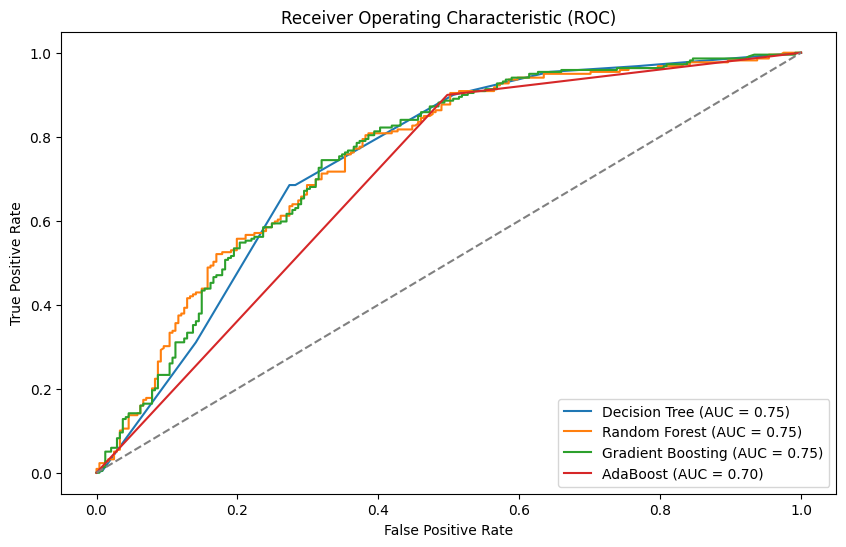

In [64]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# Plot ROC curves
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result['FPR'], result['TPR'], label=f"{result['Classifier']} (AUC = {result['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [65]:
model = AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 0.01, n_estimators= 50, random_state=42)
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01, random_state=42)

In [66]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100) + ' recall score is:{:.2f}%'.format(recall * 100))

Accuracy: 69.13% recall score is:89.95%
